Jupyter is a computing environment supporting several interpreted programming languages, cell-by-cell execution, and inline output, including rich tables and charts. It is most often paired with python. It is ideal for quick, iterative data exploration and visualization. All tools and libraries used in this short demonstration are free and open-source.

The complete code can be run by pressing the following button:

<img src="img/RunAll.png" width=800/>

In case the contents of a single cell are changed later, the cell alone can be rerun with the following button. Remeber to also rerun cells whose contents are based on what was just changed. (So perhaps even rerun everything)

<img src="img/RunCell.png" width=800/>

First we import a few libaries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as col
import pandas as pd
import math
import csv

Then we define how strongly the desire to drive fast and the desire to drive efficient are wighted in our optimization. Only the other will be optimized if either is 0.

In [2]:
factor_time = 0.8
factor_effiecency = 0.2

In [3]:
G = nx.DiGraph()
config = pd.read_csv("track_config.csv", sep=',')
G.add_node(0,v=0)
coordinate_set_dict = {0: (0,0)}

Now to the heart of the simulation: the assumptions taken for modelling. The following list defines the constants that we use to model the car.

In [4]:
g = 9.81                   # Earth gravity constant
section_length = 50        # distance resolution

# Car model with the following constants:
car_mass = 150              # weight of car and driver
diameter_tire = 0.4         # in m
roll_res = 0.02             # maybe a bit lower
gear_ratio = 5              # How many rotations the motor has to do for one roation of the wheel
drag_coeff = 0.03


# Series wound dc motor model uses the following constants:
torque_constant = 130       # in mNm/A
velocity_constant = 70      # in 1/(min * V)
anchor_resistance = 0.1     # in Ohm
torque_loss = 0.5           # in Nm

The next step is building a Graph.

Each node represents a specific combination of speed and distance.
There could be a node (300 m, 45 km/h) representing the state "the car is driving with 45km/h when he is 300 meters away the start"

Edges reprecent possible transitions between the states. For the state (300 m, 45 km/h) from above, it is possible to accelerate a little and reach state (350 m, 55 km/h) by accelerating or state (350 m, 15 km/h) by breaking.

The edge weight represents the cost to change from one state to another, weighted by the factors set above. While accelerating heavily would use a lot of fuel as such have a high effiecency-cost breaking would lose a lot of speed and as such have a high time cost. As such the lowest cost is probably somewhere in between breaking and accelerating.

In [5]:
for x in range (1, len(config.index)):
    for v in range(config.loc[x, "vmin"], config.loc[x, "vmax"]+1, 5):
        node_name = config.loc[x, "s"]*section_length+v
        G.add_node((node_name), v=v)
        coordinate_set_dict[node_name] = (x*section_length, v)
        for vold in range(v-30,v+31,5):
            if G.has_node(config.loc[x-1, "s"]*section_length+vold):
                vold_mps = vold/3.6
                v_mps = v/3.6

                time = 2 * section_length / (v_mps + vold_mps)

                gradient_angle = math.atan( (config.loc[x, "m above sea"]-config.loc[x-1, "m above sea"] ) / section_length)   #in rad
                f_roll_res = car_mass * g * math.cos(gradient_angle) * roll_res
                f_slope = car_mass * g * math.sin(gradient_angle)
                f_accel = ((v_mps-vold_mps) / time) * car_mass
                f_drag = ((v_mps+vold_mps) / 2)**2*drag_coeff

                f_total = f_accel + f_slope + f_roll_res + f_drag
                E_total = f_total * section_length

                motor_rotation_speed = ((v_mps+vold_mps)/2) * gear_ratio * 30 / ((diameter_tire/2) * math.pi)     #rotation speed in 1/min
                motor_torque = (f_total * (diameter_tire/2) / gear_ratio)

                motor_current = (motor_torque+torque_loss)*1000/torque_constant
                motor_voltage = (motor_rotation_speed / velocity_constant) + (anchor_resistance * motor_current)
                E_Motor = (motor_voltage*motor_current*time)

                # As adding up speed and fuel usage is like comparing apples and oranges, we have to prescale what we calculated so that the speed and efficiency factors have the effect we hope for.
                cost_econ = E_Motor / 20000
                cost_speed = time / 36

                # addtionally, we assume that the motor can only use and not generate energy. As such we cut off negative values.
                cost_econ = cost_econ if E_total > 0 else 0

                edge_weight = factor_time*cost_speed + factor_effiecency*cost_econ
                G.add_edge((config.loc[x-1, "s"]*section_length+vold), (config.loc[x, "s"]*section_length+v), weight=edge_weight)


We're now ready to find the best speed profile. For this we use Dijkstras algorithm for the shortest path. In this context the shortest path is the series of states that brings us from start to finish with the lowest combined cost of time and efficiency according to the factors given.

In [6]:
nodelist = nx.dijkstra_path(G, 0,config.loc[len(config.index)-1]["s"]*section_length+config.loc[len(config.index)-1]["vmin"])

outputlist = []
for i in range(len(config.index)):
     outputlist.append(G.nodes[nodelist[i]]["v"])

output = pd.DataFrame(outputlist)
output.rename(columns={0:"Speed optimal"}, inplace = True)
output['distance'] = output.index * section_length
print(output)

    Speed optimal  distance
0               0         0
1              30        50
2              60       100
3              70       150
4              75       200
5              80       250
6              80       300
7              80       350
8              80       400
9              80       450
10             80       500
11             75       550
12             65       600
13             65       650
14             70       700
15             70       750
16             70       800
17             65       850
18             60       900
19             55       950
20             50      1000
21             40      1050
22             40      1100
23             40      1150
24             40      1200
25             60      1250
26             70      1300
27             70      1350
28             70      1400
29             70      1450
30             70      1500
31             70      1550
32             70      1600


Finally we can plot the result we came up with. The blue points show the nodes of the Graph we created, the blue line our final result we came up with.


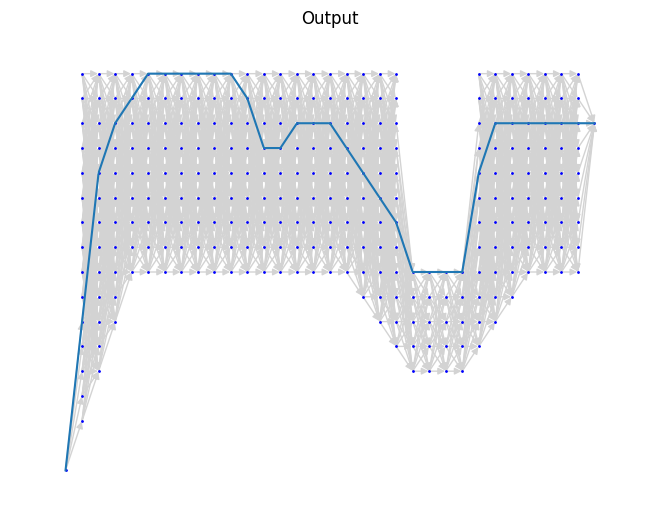

In [7]:
"""
matrix = nx.to_pandas_adjacency(G)
matrix.to_csv("AdjMatrix.csv", sep=',')
"""


weight_list = []
attributelist = nx.get_edge_attributes(G,'weight')
for edge in G.edges:
    weight_list.append(attributelist[edge])

nx.draw(G, pos=coordinate_set_dict, with_labels=False, node_color='blue', edge_color='lightgrey', node_size=1)
plt.plot(output['distance'],output['Speed optimal'])
plt.xlabel('Distance [m]')
plt.ylabel('Speed [km/h]')
plt.title('Output')

plt.show()

